# Анализ данных для построения рекомендательной системы

### Содержание:
1. [Определение задачи](#1)
2. [Загрузка данных](#2)
    1. [Загрузка и описание данных](#2.1)
    2. [Привидение типов данных](#2.2)
3. [Анализ данных](#3)
    1. [Обзор номинативных переменных](#3.1)
    2. [Обзор количественных переменных](#3.2)
    3. [Обзор целевой переменной](#3.3)
4. [Предобработка данных](#4)
    1. [Обработка пропусков](#4.1)
    2. [Обработка выбросов](#4.2) 
    3. [Генерация новых признаков](#4.3)

### 1. <a id="1">Определение задачи</a>

Создание системы рекомендаций для онлайн-кинотеатров, которая будет рекомендовать фильмы на основе индивидуальных предпочтений пользователя, тем самым максимизировать вовлеченность и заинтересованность зрителя.

### 2. <a id="2">Загрузка данных</a>

#### Импорт библиотек и скриптов

In [3]:
from datetime import datetime
import pandas as pd
import numpy as np
from IPython.display import Image

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval

matplotlib.rcParams.update({'font.size': 12})
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

sns.set_style('whitegrid')
sns.set(font_scale=1.25)
pd.set_option('display.max_colwidth', 50)

 #### <a id="2.1">Загрузка и описание данных</a>

#### Общая информация:
>Файлы содержат метаданные  86 000 фильмов, перечисленных в полном наборе данных MovieLens. 
Набор данных состоит из фильмов, выпущенных вплоть до июля 2023 года. 

#### Файлы:

>1) <b>Movies_metadata.csv</b>: основной файл метаданных фильмов. Содержит информацию о 85 000 фильмах, представленных в наборе данных Full MovieLens.</br> 
    >>**Фичи**
    >>- tmdbId: индификатор
    >>- adult: казывает, имеет ли фильм X-Rated или Adult.
    >>- belongs_to_collection: строковый словарь, который предоставляет информацию о серии фильмов, к которой принадлежит конкретный фильм.
    >>- budget: Бюджет фильма в долларах.
    >>- genres: строковый список словарей, в которых перечислены все жанры, связанные с фильмом.
    >>- homepage: официальная домашняя страница фильма.
    >>- id: идентификатор фильма.
    >>- imdb_id: идентификатор фильма на IMDB.
    >>- original_language: язык, на котором изначально был снят фильм.
    >>- original_title: оригинальное название фильма.
    >>- overview: краткая аннотация фильма.
    >>- popularity: показатель популярности, присвоенный TMDB.
    >>- poster_path: URL-адрес изображения постера.
    >>- production_companies: строковый список продюсерских компаний, участвовавших в создании фильма.
    >>- production_countries: строковый список стран, в которых был снят фильм.
    >>- release_date: дата выхода фильма в кинотеатрах.
    >>- revenue: общий доход от фильма в долларах.
    >>- runtime: время воспроизведения фильма в минутах.
    >>- spoken_languages: строковый список разговорных языков в фильме.
    >>- status: Статус фильма (Released, To Be Released, Announced, etc.)
    >>- tagline: Слоган фильма.
    >>- title: Официальное название фильма.
    >>- video: указывает, есть ли видеозапись фильма в TMDB.
    >>- vote_average: средний рейтинг фильма.
    >>- vote_count: количество голосов пользователей, подсчитанное TMDB.
2) <b>keywords.csv</b>: содержит ключевые слова сюжета (movie plot keywords) для наших фильмов MovieLens. Доступен в виде строкового объекта JSON.</br>
    >>**Фичи**
    >>- tmdbId: идентификатор фильмов, используемый <http://www.imdb.com>.
    >>- keywords: ключевые слова сюжета
3) <b>credits.csv</b>: Содержит информацию об актерах и съемочной группе (Cast and Crew) всех наших фильмов. Доступен в виде строкового объекта JSON.</br>
    >>**Фичи**
    >>- tmdbId: идентификатор фильмов, используемый <http://www.imdb.com>.
    >>- cast: актерский состав, 
    >>- crew: съемочную группу
4) <b>ratings.csv</b>: Подмножество из 33 800 000 оценок 331 000 пользователей к 85 000 фильмам.</br>
    >>**Фичи**
    >>- movieId: индификатор фильмов
    >>- userId: индификатор пользователей
    >>- rating: рейтинги, оцениваются по шкале <b>от 1 до 5</b> и получены с официального сайта GroupLens.
    >>- timestamp: время оценки
5) <b>«links.csv»</b> - идентификаторы, содержащие индификаторы фильмов, TMDB и IMDB всех фильмов, представленных в наборе данных Full MovieLens.</br>
    >>**Фичи**
    >>- movieId: индификатор фильмов 
    >>- imdbId: идентификатор фильма на IMDB
    >>- tmdbId: идентификатор фильмов, используемый <http://www.imdb.com> 

In [4]:
keywords = pd.read_csv('full_data/keywords_final.csv')
# links = pd.read_csv('full_data/links.csv')
ratings = pd.read_csv('full_data/ratings.csv')
credits = pd.read_csv("full_data/credits_final.csv")
movies_metadata = pd.read_csv("full_data/movie_metadata_final.csv")

 #### <a id="2.1">Привидение типов данных</a>

Файлы содержат достаточно внушительное количество данных. Чтобы ускорить скорость работы с ними я привожу их к менее затратным типам данных без потерь их информативности.

In [5]:
def memory_usage(df):
    return df.memory_usage(deep=True).sum()/1024**2
    
def downcast_numbers(df):
    selected_col_int = df.select_dtypes(include=['int']).columns
    selected_col_float = df.select_dtypes(include=['float']).columns
    
    memory_before = memory_usage(df[selected_col_int])+ memory_usage(df[selected_col_float])
    
    for col in selected_col_int:
        mx_col = df[col].max()
        mn_col = df[col].min()
        if mn_col > np.iinfo(np.int8).min and mx_col < np.iinfo(np.int8).max:
            df[col] = df[col].astype(np.int8)
        elif mn_col > np.iinfo(np.int16).min and mx_col < np.iinfo(np.int16).max:
            df[col] = df[col].astype(np.int16)
        elif mn_col > np.iinfo(np.int32).min and mx_col < np.iinfo(np.int32).max:
            df[col] = df[col].astype(np.int32)
        else:
            df[col] = df[col].astype(np.int64)
    for col in selected_col_float:
        mx_col = df[col].max()
        mn_col = df[col].min()
        
        if mn_col > np.finfo(np.float16).min and mx_col < np.finfo(np.float16).max:
            df[col] = df[col].astype(np.float16)
        elif mn_col > np.finfo(np.float32).min and mx_col < np.finfo(np.float32).max:
            df[col] = df[col].astype(np.float32)
        else:
            df[col] = df[col].astype(np.float64)
    memory_after = memory_usage(df[selected_col_int])+ memory_usage(df[selected_col_float])
    print(f'before the number downcast:{memory_before:.2f} MB')
    print(f'after the number downcast:{memory_after:.2f} MB')
    return df

def downcast_object(df, columns:list):
    selected_col = columns
    print(f'before the object downcast:{memory_usage(df[columns]):.2f} MB')
    for col in selected_col:
        numbr_of_unique = df[col].nunique()
        numbr_total = df[col].shape[0]
        if numbr_of_unique / numbr_total < 0.5:
            df[col] = df[col].astype('category')
    print(f'before the object downcast:{memory_usage(df[columns]):.2f} MB')
    return df

In [6]:
print('--Ratings--')
ratings = downcast_numbers(ratings)
ratings.timestamp = [datetime.fromtimestamp(x) for x in ratings['timestamp']]

print('--Keywords--')
keywords = downcast_numbers(keywords)
keywords.keywords = keywords['keywords'].fillna('[]').apply(literal_eval)

print('--Links--')
# links = downcast_numbers(links)

print('--Credits--')
credits = downcast_numbers(credits)
credits.cast = credits.cast.fillna('[]').apply(literal_eval)
credits.crew = credits.crew.fillna('[]').apply(literal_eval)

print('--Movies_metadata--')
movies_metadata = downcast_numbers(movies_metadata)
movies_metadata = downcast_object(movies_metadata, ['status', 'adult', 'video','original_language'])
movies_metadata.release_date = pd.to_datetime(movies_metadata.release_date)

--Ratings--
before the number downcast:1032.48 MB
after the number downcast:451.71 MB
--Keywords--
before the number downcast:0.65 MB
after the number downcast:0.33 MB
--Links--
--Credits--
before the number downcast:0.65 MB
after the number downcast:0.33 MB
--Movies_metadata--
before the number downcast:5.22 MB
after the number downcast:1.96 MB
before the object downcast:10.27 MB
before the object downcast:0.34 MB


In [7]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

def clean_numeric_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [8]:
movies_metadata.popularity = movies_metadata.popularity.apply(clean_numeric)
movies_metadata.vote_count = movies_metadata.vote_count.apply(clean_numeric)
movies_metadata.vote_average = movies_metadata.vote_average.apply(clean_numeric)
movies_metadata.runtime = movies_metadata.runtime.apply(clean_numeric)
movies_metadata.revenue = movies_metadata.revenue.apply(clean_numeric)

### 3.  <a id="3">Анализ данных</a>

Приведенный набор данных был получен через API TMDB. Фильмы, доступные в этом наборе данных, соответствуют фильмам, перечисленным в последнем полном наборе данных MovieLens, состоящем из 33 миллионов оценок 83 000 фильмов от 330 000 пользователей. 

Давайте посмотрим на метаданные фильмов, которые нам доступны.

In [9]:
movies_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85463 entries, 0 to 85462
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tmdbId                 85463 non-null  int32         
 1   adult                  85463 non-null  category      
 2   backdrop_path          85463 non-null  object        
 3   belongs_to_collection  85463 non-null  object        
 4   budget                 85463 non-null  float32       
 5   genres                 85463 non-null  object        
 6   homepage               17479 non-null  object        
 7   id                     85463 non-null  float32       
 8   imdb_id                85438 non-null  object        
 9   original_language      85463 non-null  category      
 10  original_title         85463 non-null  object        
 11  overview               84676 non-null  object        
 12  popularity             85463 non-null  float64       
 13  p

Первоначально полученные данные были в форме файла JSON. Они были преобразованы в файл CSV, чтобы можно было легко загрузить в DataFrame. Другими словами, набор данных, который у нас на руках, уже относительно чист. Однако я постараюсь узнать больше о наших фичах и выполнить соответствующие шаги, чтобы прийти к форме, более подходящей для анализа.

Начнем с удаления фичей, которые нам не пригодятся.

In [10]:
movies_metadata.adult.value_counts()

False    85444
True        19
Name: adult, dtype: int64

В этом наборе количество фильмов для взрослых близко к 0. Таким образом, фича adult нам не очень полезна, и ее можно смело удалить.

In [11]:
movies_metadata.drop(columns=['adult'], inplace=True)

В датасете есть три вида индификаторов: imdb_id, id и tmdbId. Из них нужен tmdbId для связи с credits и keywords, imdb_id и id (дубликат tmdbId) нам не понадобятся.

In [12]:
movies_metadata.drop(columns=['imdb_id'], inplace=True)
movies_metadata.drop(columns=['id'], inplace=True)

In [13]:
movies_metadata[movies_metadata['original_title'] != movies_metadata['title']][['title', 'original_title']].head()

,title,original_title
28,The City of Lost Children,La Cité des Enfants Perdus
29,Shanghai Triad,摇啊摇，摇到外婆桥
32,Wings of Courage,"Guillaumet, les ailes du courage"
57,The Postman,Il postino
58,The Confessional,Le Confessionnal


original_title это название фильма на родном языке, на котором фильм был снят. Я предпочту использовать в этом анализе переведенное англоязычное название и, следовательно, удалю колонку original_title. Если понадобиться информация об оригинальном языке фильма, то можно взглянуть на колонку original_language.

In [14]:
movies_metadata.drop(columns=['original_title'], inplace=True)

Указатель, есть ли видеозапись фильма в TMDB - video, домашняя страница - homepage и постеры - poster_path  и backdrop_path нам не понадобятся при анализе.

In [15]:
movies_metadata.drop(columns=['video', 'homepage', 'poster_path', 'backdrop_path'], inplace=True)

####  3.1 <a id="3.1">Обзор номинативных переменных</a>

<b> Страны</b>

In [16]:
movies_metadata['production_countries_name'] = movies_metadata.production_countries.fillna('[]').\
                    apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [17]:
s = movies_metadata.apply(lambda x: pd.Series(x['production_countries_name']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'countries'

In [18]:
con_df = movies_metadata.drop('production_countries_name', axis=1).join(s)
con_df = pd.DataFrame(con_df['countries'].value_counts())
con_df['country'] = con_df.index
con_df.columns = ['num_movies', 'country']
con_df = con_df.reset_index().drop('index', axis=1)
con_df.head(10)

,num_movies,country
0,38721,United States of America
1,7871,United Kingdom
2,7567,France
3,4407,Italy
4,4163,Canada
5,4136,Germany
6,3312,Japan
7,2452,India
8,2273,Spain
9,1274,Hong Kong


In [19]:
con_df.shape

(198, 2)

Соединенные Штаты являются самым популярным местом производства фильмов, но это неудивительно, та как наш набор данных в основном состоит из английских фильмов. Европа также является чрезвычайно популярным местом: Великобритания, Франция, Италия и Канада входят в пятерку лучших стран. Япония и Индия — самые популярные азиатские страны в кинопроизводстве.

Если пользователь имеет сильно выраженное предпочтение к фильмам определенной страны, то возможно стоит учитывать данную фичу. Это сильно заметно у более старшего поколения в нашей стране, так как они больше предпочитают фильмы и сериалы русского производства. Но к сожалению у нас нет данных о пользователях, поэтому ни возраст ни национальность узнать не получиться. Будем полагаться только на вычисление индивидуального предпочтение каждого из них.

<b>Франшизы</b>

Эта фича позволяет причислить группу фильмов к одной коллекции. Она будет полезна при анализе схожести фильмов.

In [20]:
df_fran = movies_metadata[movies_metadata['belongs_to_collection'].notnull()]
df_fran['belongs_to_collection'] = df_fran['belongs_to_collection'].apply(literal_eval).apply(lambda x: x['name'] if isinstance(x, dict) else np.nan)
df_fran = df_fran[df_fran['belongs_to_collection'].notnull()]

Так как у нас нет информации о количестве просмотров того или иного фильма, вместо этого тут и далее я буду брать показатель количества отданных голосов за фильм, как аналог количества просмотров.

In [21]:
fran_pivot = df_fran.pivot_table(index='belongs_to_collection', 
                                 values='vote_count', 
                                 aggfunc={'vote_count': ['mean', 'sum', 'count']}
                                ).reset_index()

 - Самые обсуждаемые франшизы

In [22]:
fran_pivot.sort_values('sum', ascending=False).head(10)

,belongs_to_collection,count,mean,sum
1179,Harry Potter Collection,8,19990.000000,159920.0
2517,Star Wars Collection,9,14553.777778,130984.0
2688,The Avengers Collection,4,25852.000000,103408.0
1377,James Bond Collection,26,3623.115385,94201.0
2835,The Fast and the Furious Collection,10,7788.400000,77884.0
3502,X-Men Collection,7,10592.000000,74144.0
2102,Pirates of the Caribbean Collection,5,14484.800000,72424.0
2789,The Dark Knight Collection,3,24090.666667,72272.0
2963,The Lord of the Rings Collection,3,22224.000000,66672.0
1350,Iron Man Collection,3,22064.000000,66192.0


Самыми обсуждаемыми франшизами оказались "Гарри Поттер" и "Звездные воины", которые обогнали "Мстителей" и "Джеймс Бонда". Но "Джеймс Бонд" значительно уступает по среднему количеству голосов за каждый из фильмов.

- Самые обсуждаемые кинофраншизы (по среднему количеству голосов за фильм)

In [29]:
fran_pivot.loc[fran_pivot['count'] >= 5].sort_values('mean', ascending=False).head(10)

,belongs_to_collection,count,mean,sum
1179,Harry Potter Collection,8,19990.000000,159920.0
2517,Star Wars Collection,9,14553.777778,130984.0
2102,Pirates of the Caribbean Collection,5,14484.800000,72424.0
1428,Jurassic Park Collection,6,10963.333333,65780.0
3502,X-Men Collection,7,10592.000000,74144.0
3168,The Twilight Collection,5,9294.400000,46472.0
3148,The Terminator Collection,6,8132.666667,48796.0
3289,Transformers Collection,5,7968.800000,39844.0
1325,Indiana Jones Collection,5,7887.200000,39436.0
2835,The Fast and the Furious Collection,10,7788.400000,77884.0


Самыми успешными франшизами, в которых есть хотя бы 5 фильмов, стали - Гарри Поттер, Звездные войны и Пираты Карибского моря.

- Самые продолжительные франшизы

In [24]:
fran_pivot.sort_values('count', ascending=False).head(10)

,belongs_to_collection,count,mean,sum
2735,The Bowery Boys Collection,48,2.895833,139.0
327,Beck Collection,42,19.190476,806.0
2022,Os Trapalhões: Coleção,39,25.025641,976.0
3411,Wallander Collection,32,11.812500,378.0
1768,Mazzaropi Collection,31,5.161290,160.0
508,Carry On Collection,29,55.827586,1619.0
3043,The Perry Mason TV Movie Collection,29,6.793103,197.0
398,Blondie Collection,28,3.928571,110.0
1727,Maneater Collection,26,44.269231,1151.0
1377,James Bond Collection,26,3623.115385,94201.0


Тут мы замечаем, что среди фильмов в датасете присутствует информация о некоторых сериалах. Так как конечная рекомендательная система предназначена только для рекомендаций фильмов, то нужно будет удалить все строки с сериалами.

<b>Кинокомпании</b>

In [30]:
movies_metadata['production_companies'] = movies_metadata.production_companies.fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [31]:
s = movies_metadata.apply(lambda x: pd.Series(x['production_companies']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'companies'

In [32]:
df_com = movies_metadata.drop('production_companies', axis=1).join(s)

In [33]:
com_pivot = df_com.pivot_table(index='companies', 
                                 values='vote_count', 
                                 aggfunc={'vote_count': ['mean', 'sum', 'count']}
                                ).reset_index()

- Компании с самым высоким количеством голосов

In [34]:
com_pivot.sort_values('sum', ascending=False).head(10)

,companies,count,mean,sum
43277,Warner Bros. Pictures,1792,1052.864397,1886733.0
42021,Universal Pictures,1227,1234.739201,1515025.0
171,20th Century Fox,1221,1037.420966,1266691.0
9019,Columbia Pictures,1235,996.727935,1230959.0
30122,Paramount,1318,870.794385,1147707.0
43196,Walt Disney Pictures,337,2678.362018,902608.0
28007,New Line Cinema,340,1903.700000,647258.0
25377,Marvel Studios,51,10907.019608,556258.0
23508,Lionsgate,302,1532.417219,462790.0
26048,Metro-Goldwyn-Mayer,1624,281.940887,457872.0


"Уорнер бразерс" за историю своего существования снял много фильмов и привлек внимание большой аудитории зрителей. Это одна из компаний, которая на слуху даже у самых непривередливых и мало интересующихся фильмами людей. 

In [35]:
com_pivot.sort_values('count', ascending=False).head(5)

,companies,count,mean,sum
43277,Warner Bros. Pictures,1792,1052.864397,1886733.0
26048,Metro-Goldwyn-Mayer,1624,281.940887,457872.0
30122,Paramount,1318,870.794385,1147707.0
9019,Columbia Pictures,1235,996.727935,1230959.0
42021,Universal Pictures,1227,1234.739201,1515025.0


- Самые успешные компании

Рассматрим только те компании, которые сняли не менее 15 фильмов.

In [36]:
com_pivot[com_pivot['count'] >= 15].sort_values('mean', ascending=False).head(10)

,companies,count,mean,sum
25377,Marvel Studios,51,10907.019608,556258.0
18205,Heyday Films,28,9902.250000,277263.0
16209,Genre Films,16,9300.562500,148809.0
39772,The Donners' Company,22,7127.772727,156811.0
43884,WingNut Films,21,6915.904762,145234.0
32831,RatPac Entertainment,32,6215.000000,198880.0
22834,Legendary Pictures,62,6207.225806,384848.0
99,1492 Pictures,24,6067.041667,145609.0
3990,Bad Robot,18,5942.611111,106967.0
40577,Tim Burton Productions,15,5761.333333,86420.0


Text(0, 0.5, 'Название компаний')

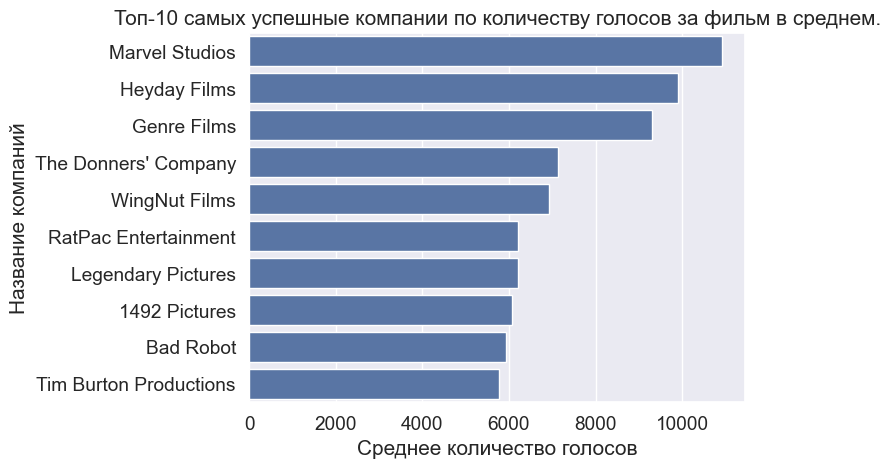

In [38]:
sns.barplot(x='mean', y='companies', data=com_pivot[com_pivot['count'] >= 15].sort_values('mean', ascending=False).head(10),
           color="b")
plt.title('Топ-10 самых успешные компании по количеству голосов за фильм в среднем.')
plt.xlabel('Среднее количество голосов')
plt.ylabel('Название компаний')

А вот самая обсуждаемая компания по среднему показателю за фильм стала компания "Марвел". Ее фильмы популярны по всему миру, множество зрителей стали фанатами их франшиз.

<b>Оригинальный язык </b>

In [37]:
movies_metadata.original_language.nunique()

122

In [39]:
lang_df = pd.DataFrame(movies_metadata['original_language'].value_counts())
lang_df['language'] = lang_df.index
lang_df.columns = ['number', 'language']
lang_df.head()

,number,language
en,53864,en
fr,5044,fr
it,3243,it
ja,2896,ja
es,2831,es


В нашем наборе данных представлено более 100 языков. Как и ожидалось, перевешивающее большинство составляют фильмы на английском языке. Французские и Итальянские фильмы занимают второе и третье места соответственно. Представим наиболее популярные языки (кроме английского) в виде столбчатой диаграммы.

In [44]:
top_lang = lang_df.iloc[1:11]
top_lang.language = top_lang.language.astype('object')

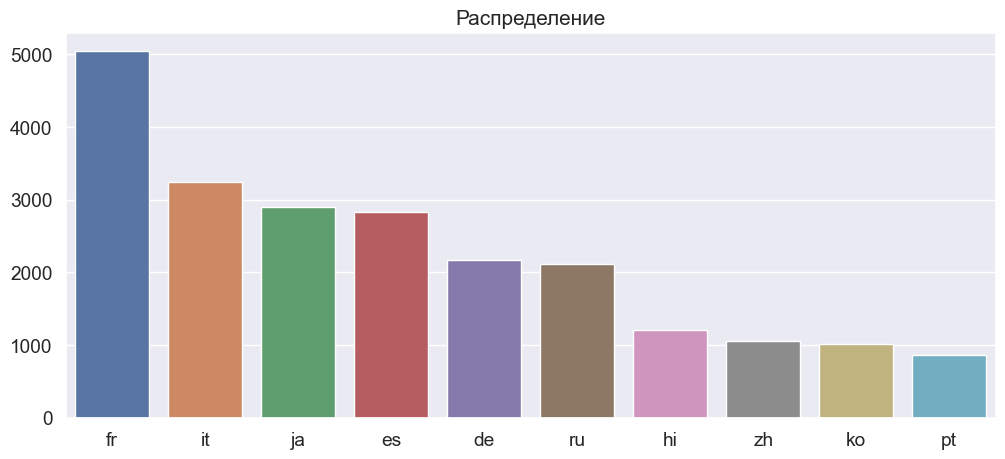

In [45]:
plt.figure(figsize=(12,5))
matplotlib.rcParams.update({'font.size': 16})
sns.barplot(x='language', y='number', data=top_lang)
plt.title('Распределение')
plt.xlabel('')
plt.ylabel('')
plt.show()

Как упоминалось ранее, французский и итальянский являются наиболее распространенными языками после английского. Русский 7-ой

Как и со страной, эта фича может сыграть весомое значение в предпочтениях пользователей. Помимо этого, это еще и показатель который легче интегрировать в алгоритм (связь с фильмами 1 к 1), а также он может быть связующим звеном между фильмами разных стран, но снятых на одном языке. 

<b> Статус фильмов</b>

In [46]:
movies_metadata['status'].value_counts()

Released           85454
Post Production        5
In Production          2
Planned                2
Name: status, dtype: int64

Будет логично рекомендовать только те фильмы, которые уже вышли, поэтому фильмы с другими статусами нужно будет предварительно удалить из рекомендаций.

<b>Spoken Languages</b>

По моему мнению, если использовать эту фичу напрямую, то она не принесет значимой добавочной ценности. Но можно преобразовать ее в числовой параметр, обозначающий количество языков, на которых говорят в фильме.

In [47]:
movies_metadata['spoken_languages'] = movies_metadata['spoken_languages'].fillna('[]').\
                apply(literal_eval).apply(lambda x: len(x) if isinstance(x, list) else np.nan)

In [48]:
movies_metadata['spoken_languages'].value_counts()

1     66960
2      9904
0      3951
3      3091
4      1008
5       347
6       122
7        39
8        18
9         9
10        7
12        3
11        2
13        1
14        1
Name: spoken_languages, dtype: int64

В большинстве фильмов на протяжении всего фильма говорят только на одном языке. 14 — это наибольшее количество языков, на которых говорят в фильме.

Так же видно, что у 3091 фильма есть пропуски. Их можно будет восполнить с помощью информации о стране производителя.

<b>Жанр</b>

Один из самых важных характеристик фильмов. Обычно предпочтения в жанрах достаточно сильно выражено среди зрителей.

In [49]:
movies_metadata['genres'] = movies_metadata['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [50]:
s = movies_metadata.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'

In [51]:
movies_metadata['year'] = movies_metadata['release_date'].apply(lambda x : str(x).split('-')[0] if x != np.nan else np.nan)
movies_metadata['year'] = movies_metadata['year'].apply(clean_numeric_int)

In [52]:
df_gen = movies_metadata.drop('genres', axis=1).join(s)

In [53]:
df_gen['genre'].value_counts().shape[0]

19

In [54]:
df_gen.to_csv('prepared_data/df_gen.csv', index=False)

TMDB определяет 19 различных жанра для нашего набора. Давайте теперь посмотрим на наиболее часто встречающиеся жанры в кино.

In [55]:
pop_gen = pd.DataFrame(df_gen['genre'].value_counts()).reset_index()
pop_gen.columns = ['genre', 'movies']
pop_gen.head(10)

,genre,movies
0,Drama,36268
1,Comedy,25164
2,Thriller,13061
3,Romance,12190
4,Action,10406
5,Documentary,9727
6,Horror,9454
7,Crime,8384
8,Adventure,6118
9,Family,5322


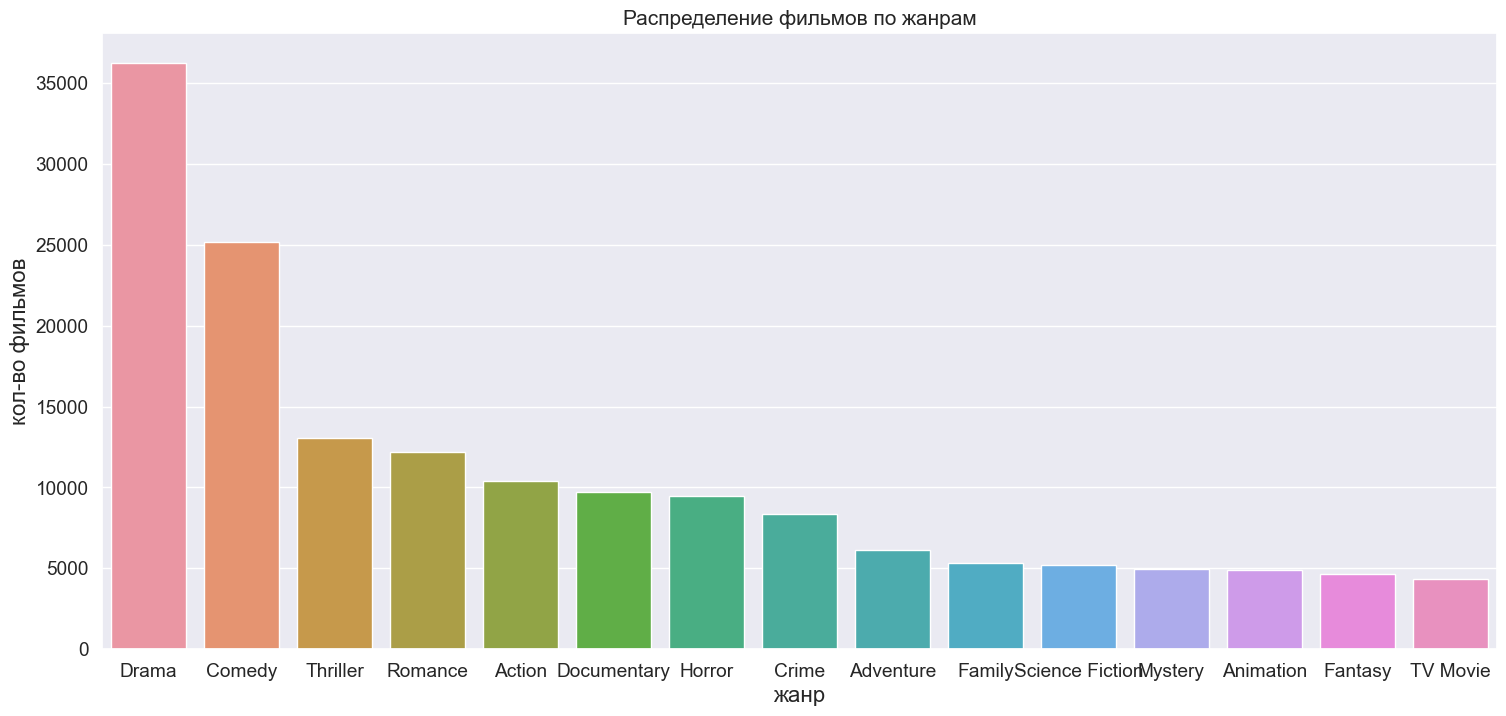

In [56]:
plt.figure(figsize=(18,8))
sns.barplot(x='genre', y='movies', data=pop_gen.head(15))
plt.title('Распределение фильмов по жанрам')
plt.xlabel('жанр')
plt.ylabel('кол-во фильмов')
plt.show()

In [57]:
pop_gen.loc[pop_gen.genre == 'Drama', 'movies'].values[0]/ movies_metadata.shape[0]

0.42437078033769

Драма — наиболее распространенный жанр: почти 42% фильмов. Комедия занимает второе место: 29% фильмов. Другими основными жанрами, представленными в топ-10, являются триллер, мелодрама, боевик, документалки, ужасы, криминал, приключения и семейные фильмы

Поссмотрим на тенденцию изменений количества фильмов разных жанров после 2000-х

In [58]:
genres = ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Documentary', 'Horror', 'Crime', 'Adventure','Family', 'Science Fiction', 'Mystery', 'Fantasy', 'Animation', 'TV Movie']

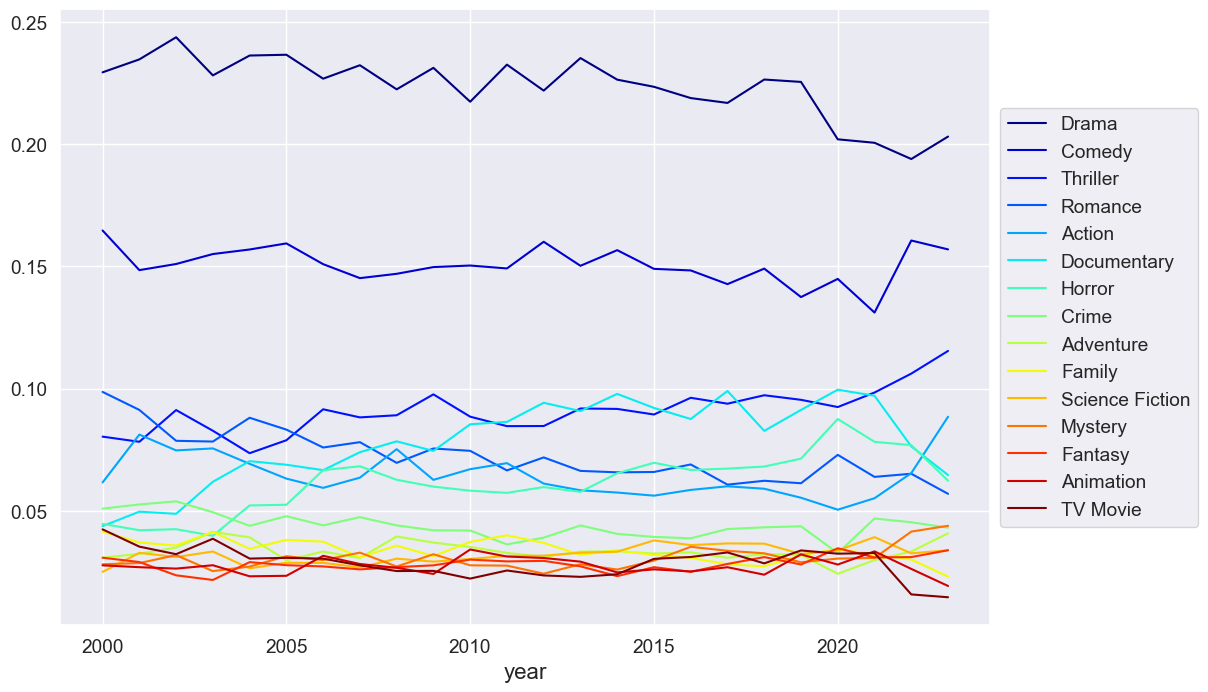

In [59]:
pop_gen_movies = df_gen[(df_gen['genre'].isin(genres)) & (df_gen['year'] >= 2000) & (df_gen['year'] <= 2023)]
ctab = pd.crosstab([pop_gen_movies['year']], pop_gen_movies['genre']).apply(lambda x: x/x.sum(), axis=1)
ctab[genres].plot(kind='line', stacked=False, colormap='jet', figsize=(12,8)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Если судить о тенденциях изменений количества фильмов разных жанров как реакция на изменения предпочтений зрителя, то можно проверить данную гипотезу и внести метод подсчета весов для жанров, исходя из их тенденции роста.

Так, например, видно, что в последние года увеличилось количество триллеров и боевиков, а документальных фильмов стало намного меньше.

<b> Актеры и съемочный состав</b>

Эти фичи находятся в файле credits, присоединим их к основному датасету

In [61]:
df = movies_metadata.merge(credits, on='tmdbId', how='left')

Из съемочного состава меня интересует только позиция директора. Напишем функцию для поиска этой информации.

In [62]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [63]:
df['director'] = df['crew'].apply(get_director)

Построим график топ директоров, которые были ответственны за фильмы с самым высоким количеством голосов

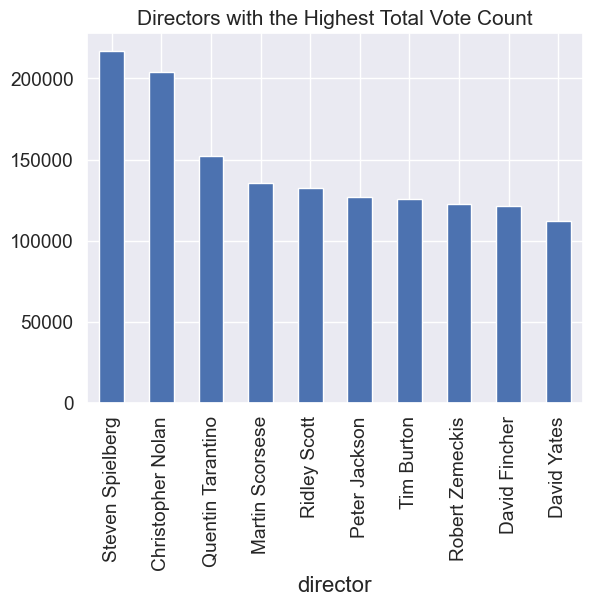

In [64]:
plt.title('Directors with the Highest Total Vote Count')
df.groupby('director')['vote_count'].sum().sort_values(ascending=False).head(10).plot(kind='bar')
plt.show()

Помимо качетственной съемки, фильм конечно же красит хорошая и качественная игра актеров. Посмотрим на топ актеров, которые снялись в фильмах с самым высоким количеством голосов

In [65]:
df['cast'] = df['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
s = df.apply(lambda x: pd.Series(x['cast']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'actor'
df_cast = df.drop('cast', axis=1).join(s)

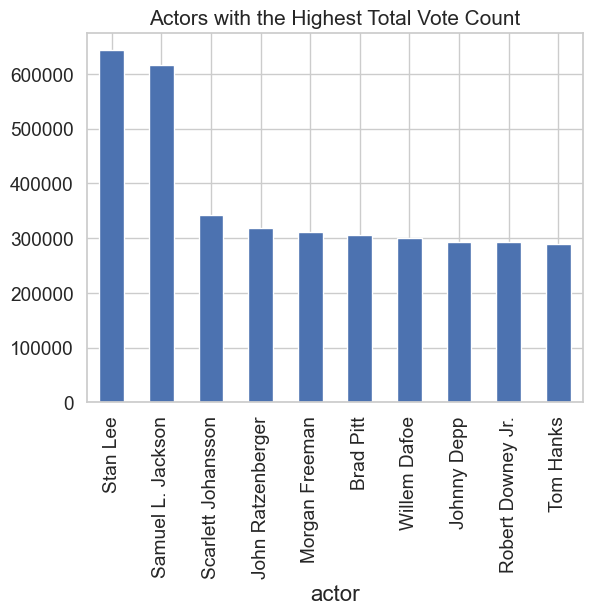

In [66]:
sns.set_style('whitegrid')
plt.title('Actors with the Highest Total Vote Count')
df_cast.groupby('actor')['vote_count'].sum().sort_values(ascending=False).head(10).plot(kind='bar')
plt.show()

Стен Ли и Самуэль Эль Джексон снялись в самых обсуждаемых фильмах.

Актерский состав, как характеристика фильма, может повлиять на предпочтения зрителей. Наверняка у каждого из нас есть те актеры, за которыми нам приятно наблюдать и мы ценим их актерские навыки, и также есть актеры, которые нам не нравятся по тем или иным причинам.

####  3.2 <a id="3.2"> Обзор количественных переменных</a>

<b> Популярность, количество голосов и средний рейтинг</b>

Давайте рассмотрим сводную статистику и распределение каждого признака по отдельности.

Начнем с популярности, которую высчитывает алгоритм TMDB:

In [68]:
movies_metadata.popularity.describe()

count    85463.000000
mean         7.385223
std         14.148283
min          0.000000
25%          1.791992
50%          3.679688
75%          8.234375
max       1645.000000
Name: popularity, dtype: float64

Средняя и медиана отличаются в два раза, это говорит о существовании правого "хвоста" или выбросов больших значений, 75% фильмов имеют рейтинг популярности ниже 8.2. Давайте посмотрим на график распределения. 

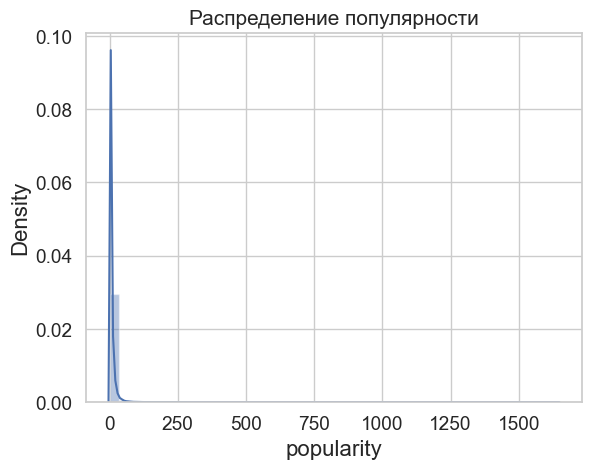

In [70]:
plt.title('Распределение популярности')
sns.distplot(movies_metadata['popularity'].fillna(movies_metadata['popularity'].median()))
plt.show()

В ситуации с этой фичей, такой длинный "хвост" не является подтверждением аномальности данных. Это происходит из-за того, что popularity сильно выделяет определенные, как она считает, "популярные" фильмы, делая разность значений с основной частью фильмов колоссально большой. 

Давайте посмотрим на топ:

In [71]:
movies_metadata[['title', 'popularity', 'year', 'genres']].sort_values('popularity', ascending=False).head(10)

,title,popularity,year,genres
85111,Oppenheimer,1645.00,2023.0,"[Drama, History]"
84996,Fast X,670.00,2023.0,"[Action, Crime, Thriller]"
85247,Mission: Impossible - Dead Reckoning Part One,653.00,2023.0,"[Action, Thriller]"
84842,Elemental,392.00,2023.0,"[Animation, Comedy, Family, Fantasy, Romance]"
84586,The Super Mario Bros. Movie,386.75,2023.0,"[Animation, Family, Adventure, Fantasy, Comedy]"
85313,Barbie,386.75,2023.0,"[Comedy, Adventure, Fantasy]"
65725,Sound of Freedom,385.25,2023.0,"[Action, Drama]"
84840,Transformers: Rise of the Beasts,381.00,2023.0,"[Action, Adventure, Science Fiction]"
84839,Spider-Man: Across the Spider-Verse,363.25,2023.0,"[Animation, Action, Adventure, Science Fiction]"
57024,The Night Crew,343.75,2015.0,"[Thriller, Action, Mystery]"


Почти все фильмы с высоким показателем популярности выпущены в этом году. Самым популярным оказался фильм-новинка "Оппенгеймер". Потом "Форсаж 10" и "Миссия невыполнима". Из мультфильмов в топе оказались "Элементарно" и "Братья Супер Марио в кино".

Я предполагаю, что данная фича является динамической, то есть показатели со временем меняются. Так же понятно, что алгоритм, который вычисляет популярность, отдает большое предпочтение новинкам. Если мои суждения верны, то я могу использовать данный параметр в вычислении весов, вместо расчета времени после выхода фильма (насколько тот или иной фильм давно вышел). Естественно данную фичу нужно будет нормализовать.

Теперь посмотрим на показатель количества голосов

In [840]:
movies_metadata.vote_count.describe()

count    85463.000000
mean       238.087898
std       1148.279005
min          0.000000
25%          7.000000
50%         20.000000
75%         69.000000
max      34784.000000
Name: vote_count, dtype: float64

Распределение количества голосов более ассиметричен, чем популярность. Среднее значение практически в 12 раз больше медианы. Наибольшее количество голосов, полученных одним фильмом, составляет 34 784. Таким образом, голоса TMDB не нормализованы, как их аналог IMDB. Тем не менее, давайте проверим, какие фильмы на сайте имеют наибольшее количество голосов.

In [841]:
movies_metadata[['title', 'vote_count', 'year']].sort_values('vote_count', ascending=False).head(10)

,title,vote_count,year
14865,Inception,34784.0,2010.0
21037,Interstellar,32960.0,2014.0
12176,The Dark Knight,30960.0,2008.0
14040,Avatar,30048.0,2009.0
16978,The Avengers,29376.0,2012.0
24890,Deadpool,29104.0,2016.0
24893,Avengers: Infinity War,28000.0,2018.0
2855,Fight Club,27552.0,1999.0
21770,Guardians of the Galaxy,26832.0,2014.0
292,Pulp Fiction,26176.0,1994.0


«Начало» и «Интерсталлер», два признанных критиками и коммерчески успешных фильма, занимают верхние строчки нашего рейтинга.

<Axes: title={'center': 'Распределение количества оценок'}, xlabel='vote_count', ylabel='Density'>

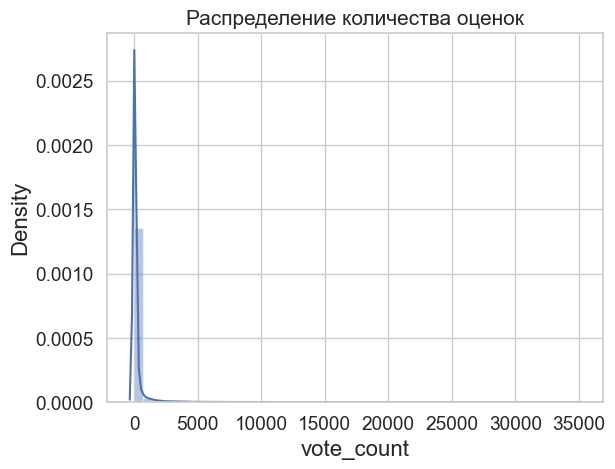

In [73]:
plt.title('Распределение количества оценок')
sns.distplot(movies_metadata['vote_count'].fillna(movies_metadata['vote_count'].median()))

Посмотрим статистику средних голосов

In [843]:
movies_metadata.vote_average.describe()

count    85463.000000
mean         5.847529
std          1.539731
min          0.000000
25%          5.281250
50%          6.101562
75%          6.800781
max         10.000000
Name: vote_average, dtype: float64

Параметр нормализован, значения находятся в отрезке от 0 до 10. Посмотрим на распределение значений:

<Axes: title={'center': 'Распределение средних оценок'}, xlabel='vote_average', ylabel='Density'>

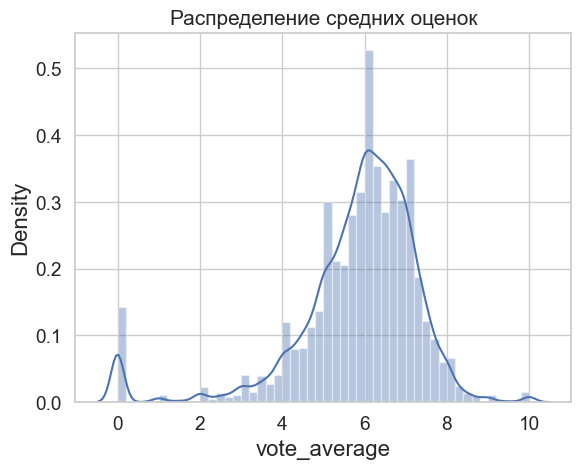

In [72]:
plt.title('Распределение средних оценок')
sns.distplot(movies_metadata['vote_average'].fillna(movies_metadata['vote_average'].median()))

Похоже, что пользователи TMDB чрезвычайно строги в своих оценках. Средний рейтинг составляет всего 5,8 по 10-балльной шкале. Половина фильмов имеет рейтинг между 5.3 и 6.8 . Давайте проверим, какие фильмы получили наибольшее признание критиков по данным TMDB. Мы будем рассматривать только те фильмы, которые набрали более 2000 голосов

In [74]:
movies_metadata[movies_metadata['vote_count'] > 2000][['title', 'vote_average', 'vote_count' ,'year']]\
                .sort_values('vote_average', ascending=False).head(10)

,title,vote_average,vote_count,year
837,The Godfather,8.710938,18992.0,1972.0
314,The Shawshank Redemption,8.703125,24976.0,1994.0
1186,The Godfather Part II,8.601562,11464.0,1974.0
522,Schindler's List,8.570312,14816.0,1993.0
1169,12 Angry Men,8.546875,7804.0,1957.0
10144,Dilwale Dulhania Le Jayenge,8.546875,4280.0,1995.0
5493,Spirited Away,8.539062,15128.0,2001.0
12176,The Dark Knight,8.515625,30960.0,2008.0
60358,Parasite,8.515625,16672.0,2019.0
3042,The Green Mile,8.507812,16160.0,1999.0


В отличии от популярности, самые высокие средние рейтинги в основном принадлежат фильмам снятых до 2000-х. «Побег из Шоушенка» и «Крестный отец» — два фильма, получившие наибольшее признание критиков согласно данным TMDB. Интересно, что они также входят в топ-2 фильмов в списке 250 лучших фильмов по версии IMDB. У них рейтинг выше 9 на IMDB по сравнению с 8,7 баллами на TMDB.

Имеют ли популярность и среднее число голосов осязаемую взаимосвязь? Другими словами, существует ли сильная положительная корреляция между этими двумя величинами? Представим их взаимосвязь в виде диаграммы рассеивания.

PearsonRResult(statistic=0.16826942256277674, pvalue=0.0)

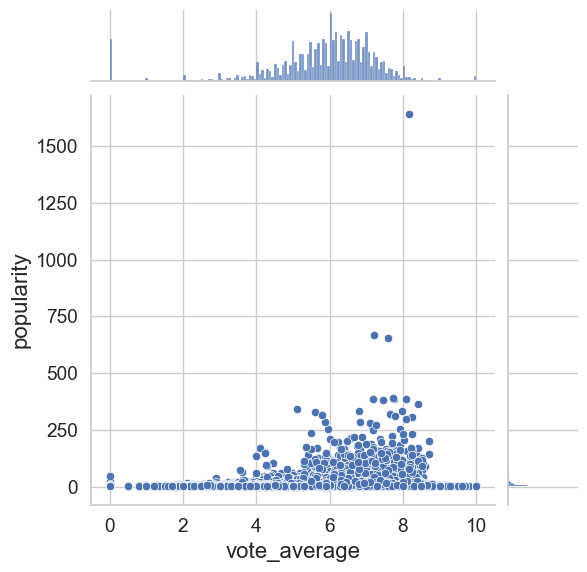

In [75]:
sns.jointplot(x='vote_average', y='popularity', data=movies_metadata)
stats.pearsonr(movies_metadata.vote_average.fillna(movies_metadata.vote_average.median()), 
               movies_metadata.popularity.fillna(movies_metadata.popularity.median()))

Коэффициент Пирсона двух вышеупомянутых величин составляет 0.17, что говорит об отсутствии ощутимой корреляции. Другими словами, популярность и средний рейтинг являются независимыми величинами. 

PearsonRResult(statistic=0.1385869505314365, pvalue=0.0)

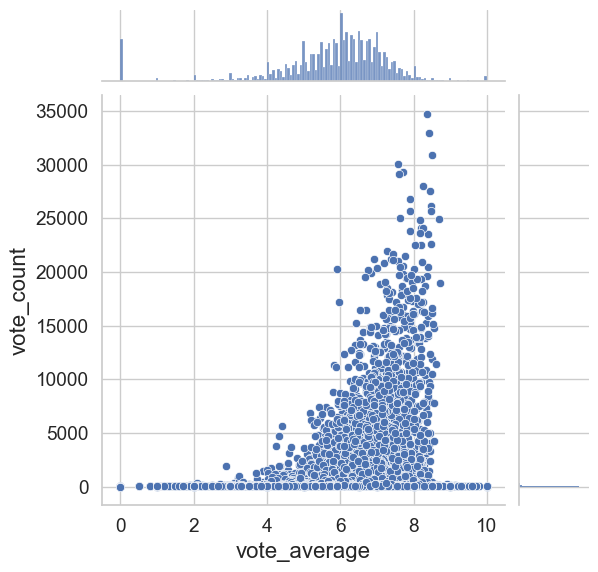

In [76]:
sns.jointplot(x='vote_average', y='vote_count', data=movies_metadata)
stats.pearsonr(movies_metadata.vote_average.fillna(movies_metadata.vote_average.median()), 
               movies_metadata.vote_count.fillna(movies_metadata.vote_count.median()))

Корреляция между количеством голосов и средним рейтингом тоже очень слабая, Коэффициент Пирсона = 0.14. Большое количество голосов за тот или иной фильм не обязательно означает, что фильм хороший, что достаточно логично.

PearsonRResult(statistic=0.5894869901898645, pvalue=0.0)

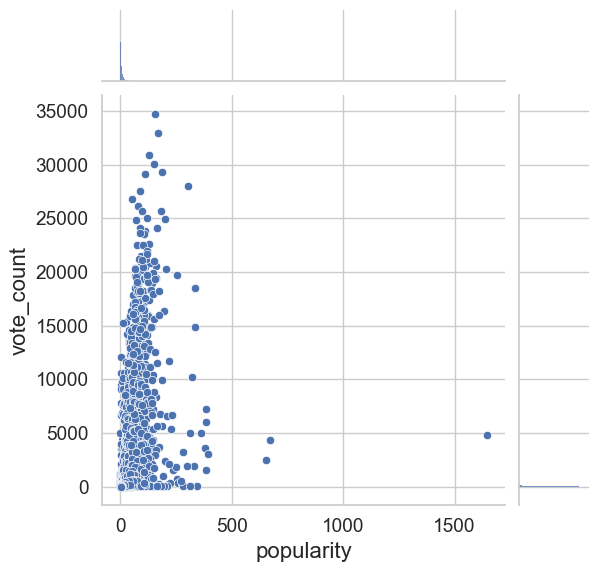

In [77]:
sns.jointplot(x='popularity', y='vote_count', data=movies_metadata)
stats.pearsonr(movies_metadata.popularity.fillna(movies_metadata.popularity.median()), 
               movies_metadata.vote_count.fillna(movies_metadata.vote_count.median()))

А вот корреляция между популярностью и количеством голосов есть - 0.58. Видимо, алгорит расчета популярности использует в вычислениях и количество голосов. 

Все три показателя являются своеобразными оценками привлекательности фильма. Ими можно воспользоваться для создание весов в алгоритме рекомендаций.

<b> Дата выхода фильма </b>

Даты выхода часто могут играть очень важную роль в рекомендациях. Мне как пользователю онлайн кинотеатров в первую очередь хочется увидеть в рекомендациях новинки, которые могли бы мне понравиться. 

Доступный нам набор данных не представляет весь набор фильмов, выпущенных с момента появления кинематографа. Однако вполне можно предположить, что сюда входят почти все крупные фильмы, выпущенные в Голливуде, а также в других крупных киноиндустриях мира (например, в Болливуде в Индии). Учитывая это предположение, давайте посмотрим на количество фильмов, выпущенных за год.

<Axes: title={'center': 'Количество снятых фильмов по годам'}, xlabel='year', ylabel='количество фильмов'>

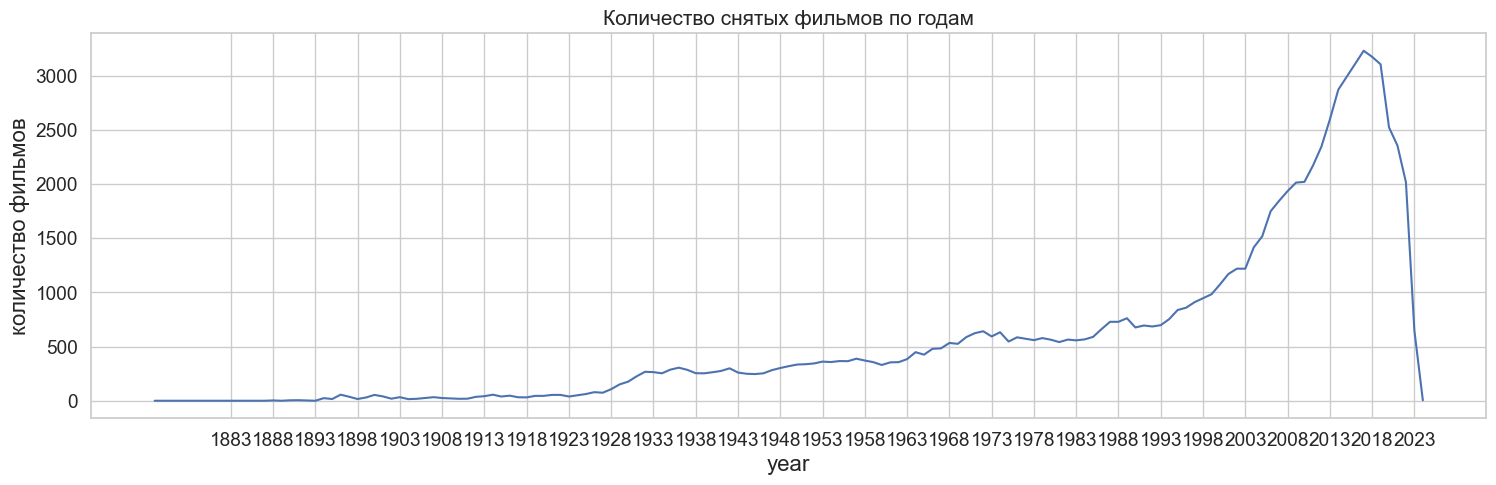

In [80]:
year_count = movies_metadata.groupby('year')['title'].count()
plt.figure(figsize=(18,5))
plt.title('Количество снятых фильмов по годам')
plt.xlabel('год')
plt.ylabel('количество фильмов')
plt.xticks([x for x in np.arange(1883, 2024, 5)])
plt.xticks(rotation=90)
year_count.plot()

In [876]:
s = pd.DataFrame(year_count.sort_values(ascending=False))
s['year'] = s.index
s.columns = ['count', 'year']
s = s.reset_index(drop=True)
s[(s.year > 2010) & (s.year <=2022)]

,count,year
0,3229,2017.0
1,3173,2018.0
2,3109,2016.0
3,3104,2019.0
4,2989,2015.0
5,2870,2014.0
6,2594,2013.0
7,2522,2020.0
8,2354,2021.0
9,2344,2012.0


Количество выпущенных фильмов с каждым годом увеличивалось вплоть до 2017 года, где дошло до своего пикового значения в 3229 фильмов за год. Потом показатель падает. В 2022 году количество фильмов равно 2016 единиц.
Значение для 2023 неполные. Датасет включает данные только до июля 2023 года.

Я ожидала, что спад придется на 2019-2020 года, но он оказался раньше по неизвестным мне причинам.

<b>Время оценки</b>

Помимо данных о дате выпуска фильма, есть еще и время, в которое пользователи ставили свои оценки. Извлечем из них год и время дня, посмотрим на их распределение

In [81]:
ratings['year'] = ratings['timestamp'].apply(lambda x : str(x).split('-')[0] if x != np.nan else np.nan)
ratings['year'] = ratings['year'].apply(clean_numeric_int)

In [82]:
def get_day_part(x):
    try:
        answer = int(str(x).split(' ')[1].split(':')[0])
        if answer < 6:
            return 'night'
        elif answer <12:
            return 'morning'
        elif answer < 18:
            return 'afternoon'
        else:
            return 'evening'
    except:
        return np.nan

In [83]:
ratings['day_part'] = ratings['timestamp'].apply(get_day_part)

Посмотрим на изменения количества оценок в течении дня

<Figure size 800x800 with 0 Axes>

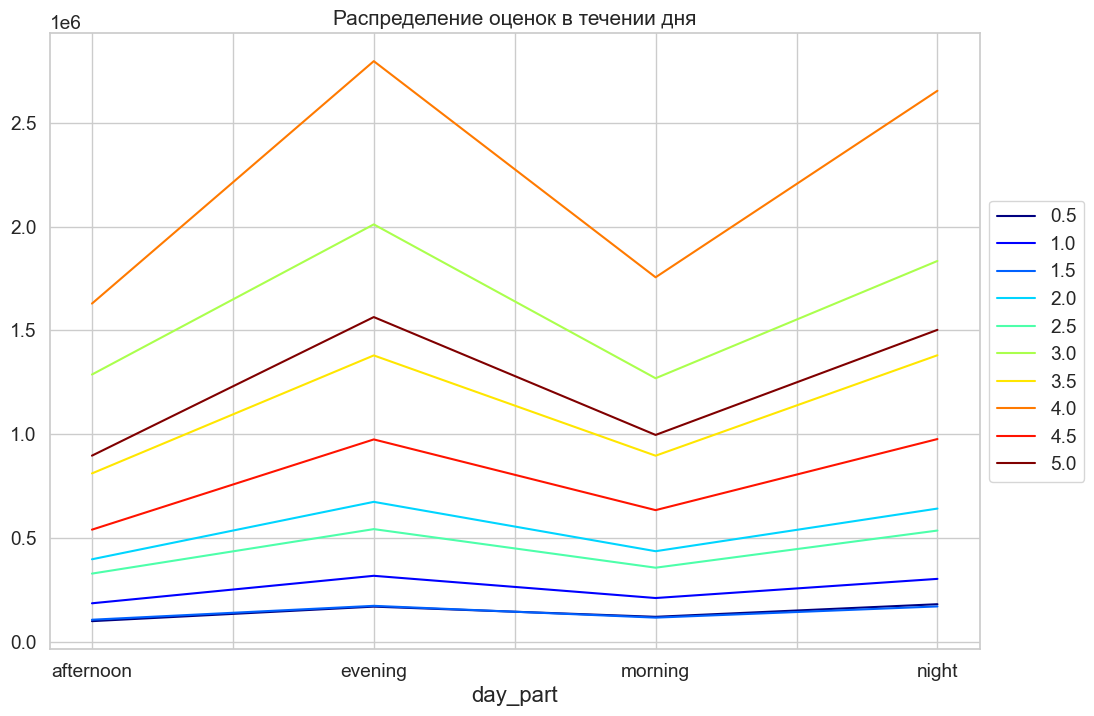

In [87]:
rating = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
plt.figure(figsize=(8,8))
rtab = pd.crosstab([ratings['day_part']], ratings['rating'])
rtab[rating].plot(kind='line', stacked=False, colormap='jet', figsize=(12,8)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Распределение оценок в течении дня')
plt.show()

Пик времени, когда больше всего ставят оценки приходится на вечер, с 18 - 24 часов. Меньше всего ставят оценки в послеобеденное время с 12 - 18. Данный график соответствует стандартному распределению активности в интернете. 

Интересно, что не зависимо от времени дня соотношение оценок практически не меняется.

<Axes: xlabel='year'>

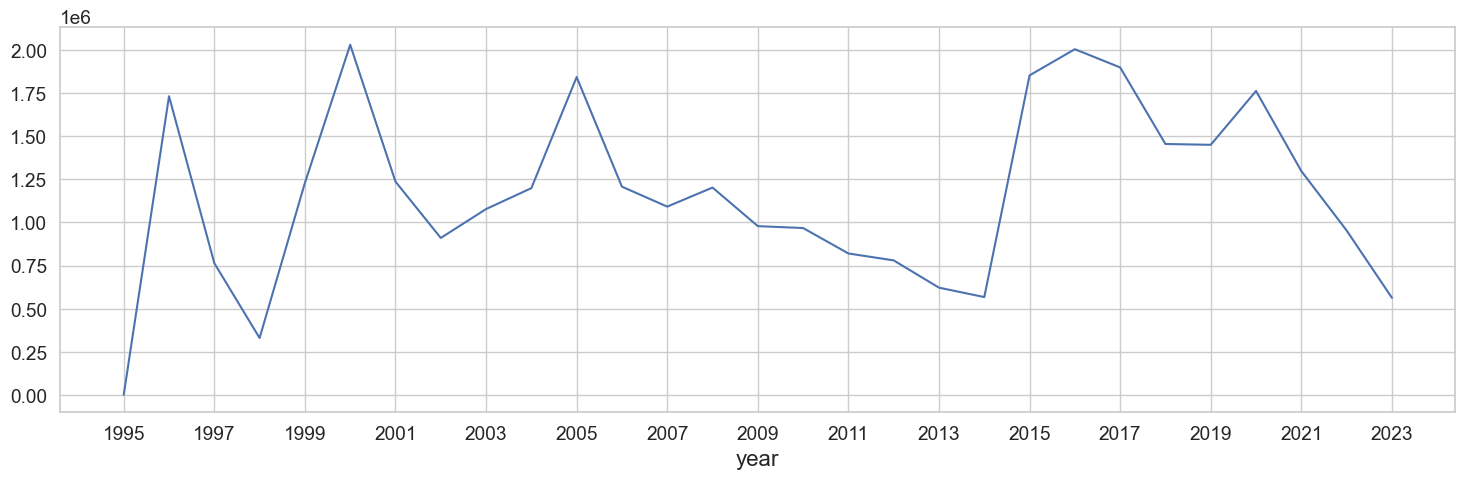

In [88]:
year_count = ratings.groupby('year')['timestamp'].count()
plt.figure(figsize=(18,5))
plt.xticks([x for x in np.arange(1993, 2024, 2)])
year_count.plot()

Нет какой-то видимой тенденции в изменении количества оценок. Есть спад с 2005 по 2014 года. Странно, что пик приходится на 2000 год. Интересно как собирались оценки до 2000-х.

<b>Продолжительность фильма</b>

In [89]:
movies_metadata['runtime'].describe()

count    85463.000000
mean        90.965108
std         53.963262
min          0.000000
25%         83.000000
50%         93.000000
75%        105.000000
max      12480.000000
Name: runtime, dtype: float64

Все нулевые значения являются пропусками. Заменяем их на nan.

In [90]:
movies_metadata['runtime'] = movies_metadata['runtime'].replace(0, np.nan)

Средняя продолжительность фильма составляет 1 часа 30 минут. Продолжительность самого длинного фильма в этом наборе данных составляет ошеломляющие 12 480 минут (или 208 часов).

In [92]:
movies_metadata[['title','runtime']].sort_values('runtime', ascending=False).head(10)

,title,runtime
72674,Cinématon,12480.0
75908,Music with Roots in the Aether: Opera for Tele...,840.0
49686,The Reality of Me,840.0
59375,La Flor,803.0
53356,Out 1,743.0
63941,Evolution of a Filipino Family,647.0
52794,Kingdom Hospital,608.0
35183,The Untold History Of The United States,585.0
76581,News from Ideological Antiquity: Marx – Eisens...,570.0
6757,Shoah,566.0


Как и ожидалось, в базу данных попали сериалы, включая самый продолжительный в датасете - "Синематон". На этапе очистки данных нужно будет исключить из датасета сериалы.

Возьмем за правило, что продолжительность большинства фильмов составляет менее 5 часов (или 300 минут). Давайте построим график распределения этих фильмов.

<Axes: title={'center': 'Распределение продолжительности фильмов'}, xlabel='runtime', ylabel='Density'>

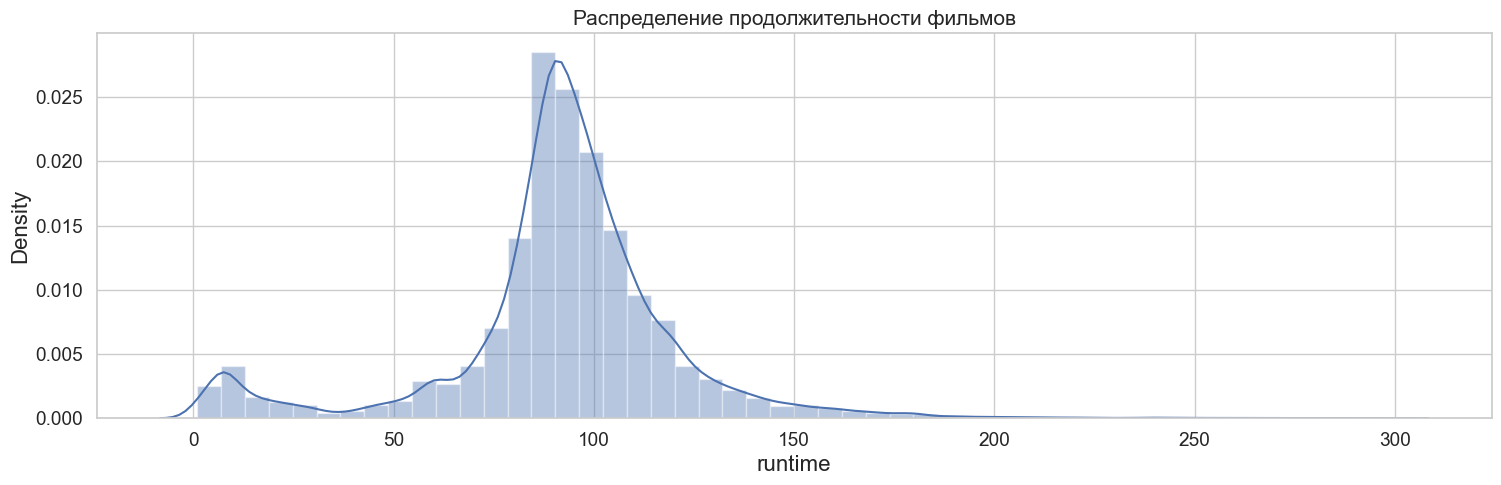

In [97]:
plt.figure(figsize=(18,5))
plt.title('Распределение продолжительности фильмов')
sns.distplot(movies_metadata[(movies_metadata['runtime'] < 300) & (movies_metadata['runtime'] > 0)]['runtime'])

Есть группа фильмов, которые имеют продолжительность менее 30 минут 

<Axes: xlabel='runtime', ylabel='Density'>

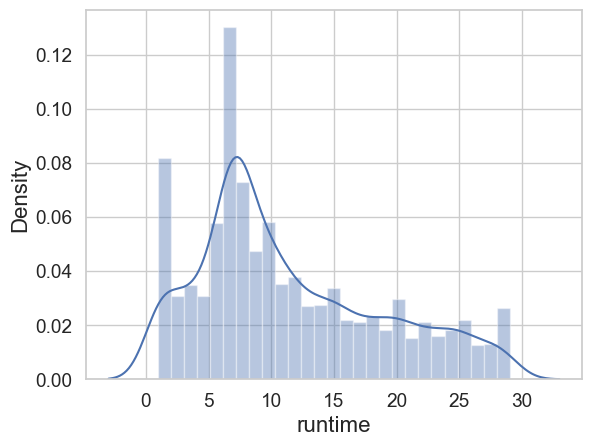

In [98]:
sns.distplot(movies_metadata[(movies_metadata['runtime'] < 30) & (movies_metadata['runtime'] > 0)]['runtime'])

In [99]:
movies_metadata[movies_metadata['runtime'] > 0][['runtime', 'title', 'year']].sort_values('runtime').head(10)

,runtime,title,year
78957,1.0,Scenes From My Balcony,1901.0
69261,1.0,Serpentine Dance,1897.0
69260,1.0,Chicago Police Parade,1896.0
69259,1.0,"New York, Broadway",1896.0
69258,1.0,Lyon : Quai de l'Archevêché,1896.0
53620,1.0,Let's All Go to the Lobby,1957.0
69257,1.0,"Venise, arrivée en gondole",1896.0
69256,1.0,"London, Cinematography Entry",1896.0
15576,1.0,The Human Pyramid,1899.0
69255,1.0,Bassin des Tuileries,1896.0


Такие фильмы не являются выбросами. Это короткометражные фильмы, снятые в далекие года 19-го века.

<b>Бюджет</b>

In [100]:
movies_metadata['budget'].describe()

count    8.546300e+04
mean     3.036137e+06
std      1.516878e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.600000e+08
Name: budget, dtype: float64

In [101]:
movies_metadata[movies_metadata.budget==0].shape[0],movies_metadata['budget'].isna().sum(), movies_metadata.shape[0]

(70889, 0, 85463)

У фичи бюджета есть нулевые значения, которые указывают на пропуски. Хотя это составляет большую часть доступных нам фильмов, я по-прежнему буду использовать бюджет как чрезвычайно важную фичу. Я преобразую все значения 0 в NaN, чтобы указать отсутствие информации.

In [102]:
movies_metadata['budget'] = movies_metadata['budget'].replace(0, np.nan)

<Axes: title={'center': 'Распределение бюджета'}, xlabel='budget', ylabel='Density'>

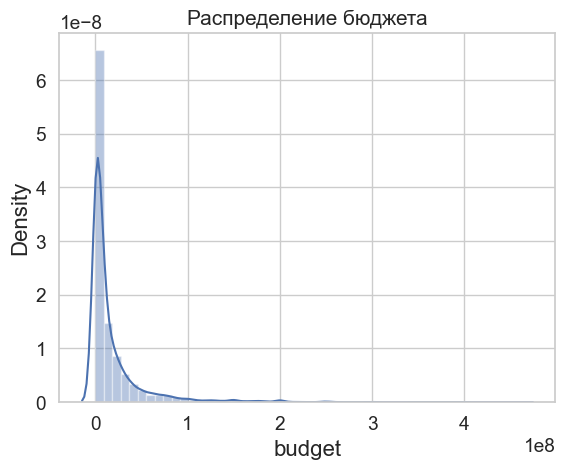

In [104]:
plt.title('Распределение бюджета')
sns.distplot(movies_metadata[movies_metadata['budget'].notnull()]['budget'])

<Axes: ylabel='Frequency'>

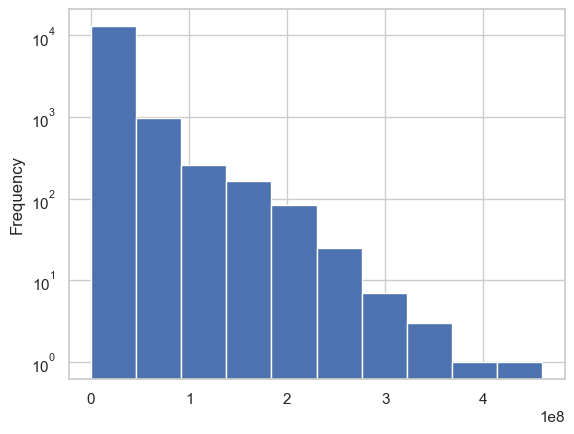

In [947]:
movies_metadata['budget'].plot(logy=True, kind='hist')

Проверим насколько сильна корреляция бюджета с доходами

PearsonRResult(statistic=0.7452526866729322, pvalue=0.0)

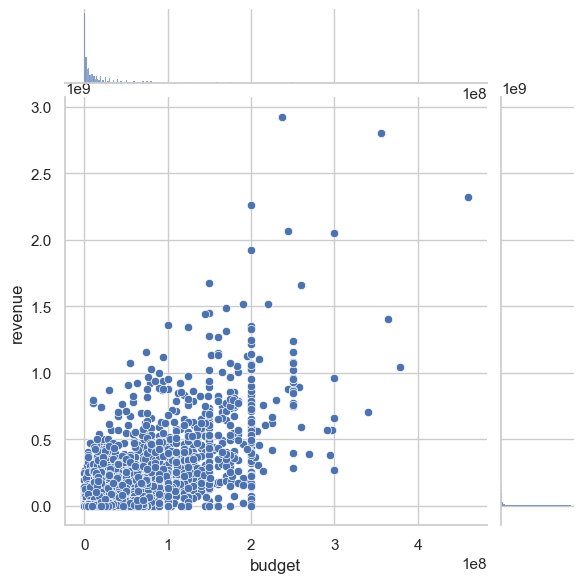

In [948]:
sns.jointplot(x='budget',y='revenue',data=movies_metadata[movies_metadata['budget'].notnull()])
stats.pearsonr(movies_metadata.loc[movies_metadata['budget'].notnull(), 'budget'], 
               movies_metadata.loc[movies_metadata['budget'].notnull(), 'revenue'])

Значение Пирсона r 0,74 между двумя величинами указывает на очень сильную взаимосвязь между ними. То есть фильм с высоким бюджетом обычно получает большую прибыль.

<b>Общий доход</b>

In [105]:
movies_metadata['revenue'].describe()

count    8.546300e+04
mean     8.160487e+06
std      5.779563e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.923706e+09
Name: revenue, dtype: float64

In [106]:
movies_metadata[movies_metadata.revenue==0].shape[0], movies_metadata.revenue.isna().sum(), movies_metadata.shape[0]

(72333, 0, 85463)

Мы видим, что у большинства фильмов информация о доходе также отсутствует. Проводим такую же замену 0 на NaN.

In [107]:
movies_metadata['revenue'] = movies_metadata['revenue'].replace(0, np.nan)

<Axes: title={'center': 'Распределение дохода'}, xlabel='revenue', ylabel='Density'>

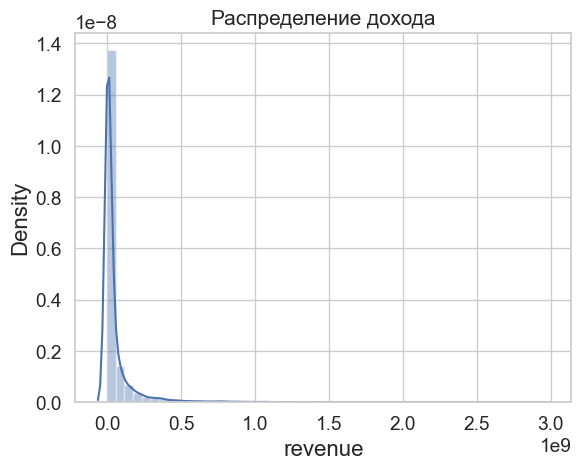

In [109]:
plt.title('Распределение дохода')
sns.distplot(movies_metadata[movies_metadata['revenue'].notnull()]['revenue'])

Распределение доходов претерпевает экспоненциальный спад, как и бюджет. Эти две величины еще и сильно коррелируют.

Цифры доходов не скорректированы с учетом инфляции. Поэтому в топ-10 мы увидим непропорционально большое количество фильмов недавнего времени. 

In [110]:
movies_metadata[['title', 'budget', 'revenue', 'year']].sort_values('revenue', ascending=False).head(5)

,title,budget,revenue,year
14040,Avatar,237000000.0,2.923706e+09,2009.0
24894,Avengers: Endgame,356000000.0,2.800000e+09,2019.0
82643,Avatar: The Way of Water,460000000.0,2.320250e+09,2022.0
1649,Titanic,200000000.0,2.264162e+09,1997.0
24882,Star Wars: The Force Awakens,245000000.0,2.068224e+09,2015.0


Чтобы получить представление о доходах, полученных от фильмов, давайте построим график максимального дохода за годы.

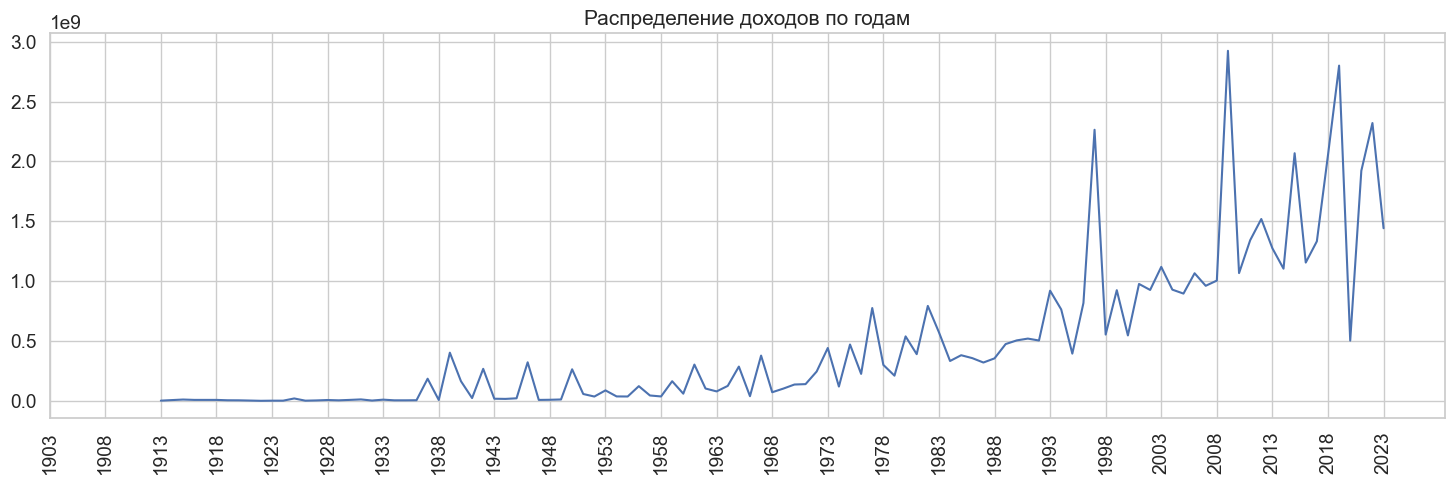

In [112]:
plt.figure(figsize=(18,5))
year_revenue = movies_metadata[(movies_metadata['revenue'].notnull()) & (movies_metadata['year'].notnull())].groupby('year')['revenue'].max()
plt.plot(year_revenue.index, year_revenue)
plt.xticks([float(x) for x in np.arange(1903, 2024, 5)])
plt.xticks(rotation=90)
plt.title('Распределение доходов по годам')
plt.show()

Как видно из графика, максимальный доход с годами неуклонно растет. Мир кино преодолел отметку в 2 миллиарда долларов в 1997 году с выходом на экраны «Титаника». Потребовалось еще 12 лет, чтобы практически преодолеть отметку в 3 миллиарда долларов с «Аватаром». Оба этих фильма снял Джеймс Кэмерон.

В 2020 год, скорее всего из-за пандемии,доходы от фильмов в целом резко сократились, но за год вернулись в на достойный уровень.

Построим корреляционную матрицу по всем количественным фичам.

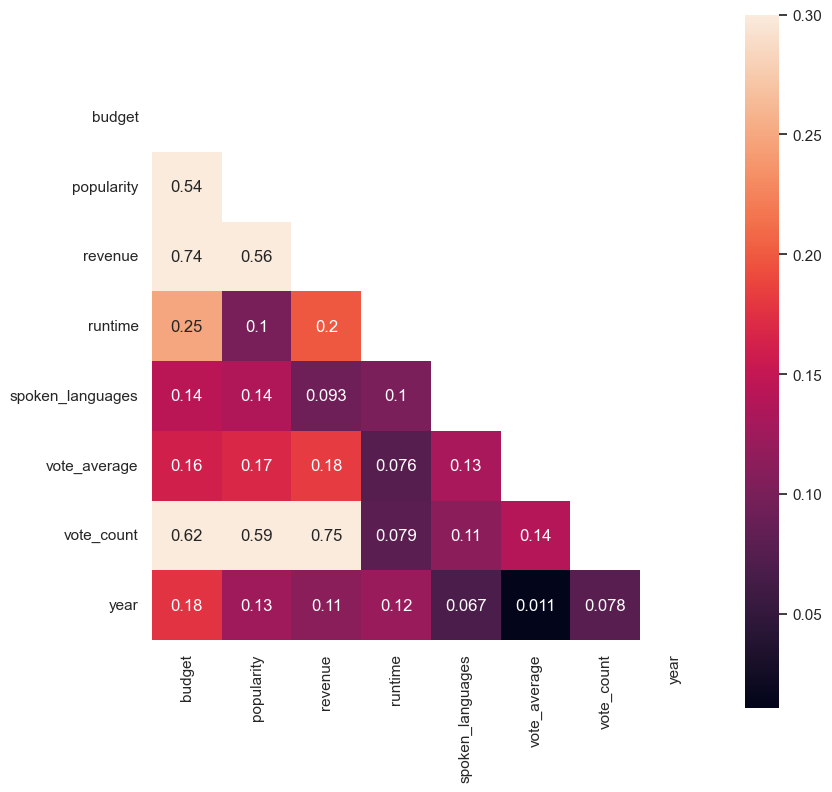

In [113]:
sns.set(font_scale=1)
corr = movies_metadata.drop(columns=['tmdbId']).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize=(9,9))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True)

Как мы ранее обнаружили, бюджет и доходы сильно коррелируют, также бюджет и количество голосов имеют положительную корреляцию в 0.62. Можно предположить, что высокобюджетные фильмы привлекают больше просмотром, тем самым получаю больший доход. 

Самый высокий показатель корреляции в датасете между количеством голосов и доходом. Параметр популярности тоже с ними коррелирует, видимо при расчете популярности значения количества голосов и дохода использовались напрямую. 

Неожиданностью стало, что взаимосвязь между популярностью и годом составляет всего 0.13. Можно сказать, что прямой связи между этими признаками нет, но возможно есть нелинейная. Для ее поиска потребуется более глубокий анализ.

#### <a id="3.3">Обзор целевой переменной</a>

Рекомендательная система будет прогнозировать оценку пользователей фильмам и на основе этих предсказаний составлять N-топ фильмов

Данные оценок находятся в файле ratings колонка rating. Каждый рейтинг находится в диапазоне от 0 до 5, с шагом 0.5. Т.е. пользователи могут поставить такие оценки как 0.5, 1.5 и т.д.

Посмотрим на распределение собранных оценок.

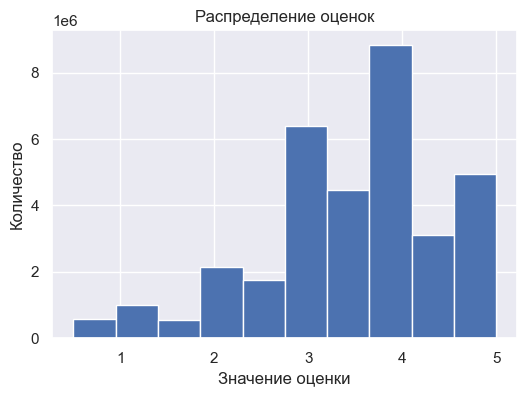

In [114]:
plt.figure(figsize = (6, 4))
plt.hist(ratings.rating)

plt.title("Распределение оценок")
plt.xlabel("Значение оценки")
plt.ylabel("Количество")

plt.show()

Больше всего было поставлено 4 и 3 (45% от всех оценок), чуть реже ставили 5. Все-таки пользователи больше склонны придерживаться середины и ставить средние оценки, нежели чем низкие или сильно высокие. При том, что если оценка не стоит, это не значит, что пользователь не смотрел данный фильм. Следовательно в случае отсутствия оценки пользователь или не смотрел данный фильм, или же воздержался ставить оценку.

### 4. <a id="4">Предобработка данных</a>

In [115]:
keywords = pd.read_csv('full_data/keywords_final.csv')
# links = pd.read_csv('full_data/links.csv')
ratings = pd.read_csv('full_data/ratings.csv')
credits = pd.read_csv("full_data/credits_final.csv")
movies_metadata = pd.read_csv("full_data/movie_metadata_final.csv")

In [116]:
print('--Ratings--')
ratings = downcast_numbers(ratings)
ratings.timestamp = [datetime.fromtimestamp(x) for x in ratings['timestamp']]

print('--Keywords--')
keywords = downcast_numbers(keywords)

print('--Credits--')
credits = downcast_numbers(credits)

print('--Movies_metadata--')
movies_metadata = downcast_numbers(movies_metadata)
movies_metadata = downcast_object(movies_metadata, ['status', 'adult', 'video','original_language'])
movies_metadata.release_date = pd.to_datetime(movies_metadata.release_date)

--Ratings--
before the number downcast:1032.48 MB
after the number downcast:451.71 MB
--Keywords--
before the number downcast:0.65 MB
after the number downcast:0.33 MB
--Credits--
before the number downcast:0.65 MB
after the number downcast:0.33 MB
--Movies_metadata--
before the number downcast:5.22 MB
after the number downcast:1.96 MB
before the object downcast:10.27 MB
before the object downcast:0.34 MB


In [117]:
movies_metadata.drop(columns=['adult', 'imdb_id', 'id', 'original_title', 'video', 'homepage', 'poster_path', 'backdrop_path'], inplace=True)

#### Распаковка JSON признаков

In [118]:
movies_metadata['production_countries_name'] = movies_metadata.production_countries.fillna('[]').\
                    apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [119]:
movies_metadata['spoken_languages_code'] = movies_metadata['spoken_languages'].\
                apply(literal_eval).apply(lambda x:  [i['iso_639_1'] for i in x] if len(x)!=0 else np.nan)

In [120]:
movies_metadata['genre_name'] = movies_metadata['genres'].\
                apply(literal_eval).apply(lambda x:  [i['name'] for i in x] if  isinstance(x, list) else [])

In [121]:
movies_metadata['collection_name'] = movies_metadata['belongs_to_collection'].apply(literal_eval)\
                .apply(lambda x: x['name'] if isinstance(x, dict) else np.nan)

In [122]:
movies_metadata['production_companies_name'] = movies_metadata.production_companies.fillna('[]')\
            .apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [123]:
credits['director'] = credits['crew'].fillna('[]').apply(literal_eval).apply(get_director)

In [124]:
credits['actors'] = credits['cast'].fillna('[]').apply(literal_eval)\
            .apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [125]:
keywords['keywords_name'] = keywords['keywords'].fillna('[]').apply(literal_eval)\
            .apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

#### <a id="4.1">Обработка пропусков</a>

In [126]:
movies_metadata.isna().sum()

tmdbId                           0
belongs_to_collection            0
budget                           0
genres                           0
original_language                0
overview                       787
popularity                       0
production_companies             0
production_countries             0
release_date                    64
revenue                          0
runtime                          0
spoken_languages                 0
status                           0
tagline                      45896
title                            0
vote_average                     0
vote_count                       0
production_countries_name        0
spoken_languages_code         3951
genre_name                       0
collection_name              76660
production_companies_name        0
dtype: int64

- budget, revenue

In [127]:
movies_metadata['budget_nan'] = 0
movies_metadata.loc[movies_metadata.budget==0, 'budget_nan'] = 1
movies_metadata['revenue_nan'] = 0
movies_metadata.loc[movies_metadata.revenue==0, 'revenue_nan'] = 1

In [128]:
movies_metadata.budget = movies_metadata.budget.astype('int')
movies_metadata.revenue = movies_metadata.revenue.astype('int')

- overview

overview текстовый признак. Обработаем пропуски, заменив его на пустую строку.

In [129]:
movies_metadata.head(3).overview

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
Name: overview, dtype: object

In [130]:
movies_metadata.overview = movies_metadata.overview.fillna('')

- release_date

In [131]:
movies_metadata.loc[movies_metadata.release_date.isna(), 'status'].value_counts()

Released           58
Post Production     4
Planned             2
In Production       0
Name: status, dtype: int64

Тут оказались 6 из 9 не вышедших фильмов. Общее количество незначительно, поэтому удалим эти фильмы.

In [132]:
movies_metadata.drop(movies_metadata.loc[(movies_metadata.release_date.isna())].index, inplace=True)

- production_countries

In [133]:
movies_metadata.loc[movies_metadata.production_countries=='[]'].shape

(6371, 25)

In [134]:
movies_metadata['production_countries_size'] = movies_metadata.production_countries_name.fillna('[]').\
                    apply(lambda x: len(set(x)) if isinstance(x, list) else np.nan)

In [135]:
lang_coun = movies_metadata.loc[movies_metadata.production_countries_size==1][['original_language', 'production_countries_name']]
lang_coun = lang_coun.groupby('original_language')['production_countries_name'].sum()

In [136]:
lang_coun = lang_coun.apply(lambda x: [max(x, key=x.count)] if isinstance(x, list) else [])
lang_coun = lang_coun.to_dict()

In [137]:
movies_metadata['production_countries_name'] = movies_metadata[['production_countries', 'original_language', 'production_countries_name']]\
                .apply(lambda x : lang_coun[x[1]] if x[0]== '[]' else x[2], 1)

- spoken_languages

In [138]:
movies_metadata[movies_metadata['spoken_languages']=='[]'].shape

(3904, 26)

In [139]:
movies_metadata['spoken_languages_code'] = movies_metadata[['original_language', 'spoken_languages_code']].\
                    apply(lambda x: x[1] if isinstance(x[1], list) else [x[0]], 1)

- genres

In [140]:
movies_metadata[movies_metadata['genres']=='[]'].shape

(1458, 26)

In [141]:
coll_genre = movies_metadata.groupby('collection_name')['genre_name'].sum()
coll_genre = coll_genre.apply(lambda x: list(set(x)))
coll_genre = coll_genre.to_dict()

In [142]:
movies_metadata['genre_name'] = movies_metadata[['genre_name', 'collection_name']].apply(lambda x: [] if not isinstance(x[1], str) else (coll_genre[x[1]] if len(x[0])==0 else x[0]), 1)

In [143]:
movies_metadata['genre_nan'] = movies_metadata.genre_name.apply(lambda x: 0 if  len(x)!=0 else 1)
movies_metadata['genre_name'] = movies_metadata.genre_name.apply(lambda x: x if  len(x)!=0 else 'Unknown_genre')

- collection_name

In [145]:
movies_metadata['has_collection'] = 1
movies_metadata.loc[movies_metadata.collection_name.isna(), 'has_collection'] = 0
movies_metadata.collection_name = movies_metadata.collection_name.fillna('')

- tagline

In [146]:
movies_metadata.tagline = movies_metadata.tagline.fillna('')

In [147]:
movies_metadata.isna().sum().sum()

0

#### <a id="4.2">Обработка выбросов</a>

удаляем сериалы

- по количеству фильмов в колекции я нашла следующие названия сериалов:

In [148]:
serial_collections = ['Beck Collection','Maneater Collection', 'Blondie Collection', 'The Perry Mason TV Movie Collection',
                     'The Bowery Boys Collection','Os Trapalhões: Coleção','Carry On Collection', 'Lupin the 3rd',
                     'Sharpe Collection', 'Johan Falk GSI Collection', 'Uuno Turhapuro Collection', 
                      'Detective Conan Collection', 'One Piece Collection', 'Monster High Collection',
                     'The Falcon Series', 'Schoolgirl Report Collection', 'Lone Wolf Collection', 
                     'Dr. Kildare Collection', 'Zatoichi: The Blind Swordsman Collection']

In [149]:
movies_metadata.drop(movies_metadata.loc[movies_metadata.collection_name.isin(serial_collections)].index, inplace=True)

- по продолжительности фильма, превышающее 5 часов

In [150]:
movies_metadata.loc[movies_metadata.runtime > 300].shape

(74, 28)

In [151]:
movies_metadata.drop(movies_metadata.loc[movies_metadata.runtime > 300].index, inplace=True)

Удаляем из списка фильмы еще не вышедшие на экран

In [152]:
movies_metadata.drop(movies_metadata.loc[movies_metadata['status'] != 'Released'].index, inplace=True)

In [153]:
movies_metadata.loc[movies_metadata.release_date > '2024-01-01'][['tmdbId', 'title', 'release_date', 'collection_name']].\
                sort_values('release_date')

,tmdbId,title,release_date,collection_name
83325,891933,Sometimes I Think About Dying,2024-01-26,
23493,65456,The Atrocity Exhibition,2024-02-15,
82758,1024721,Monolith,2024-07-17,


У этих трех фильмов проставлена неправильная дата выхода. Так например "The Atrocity Exhibition" вышел в 1998 году, а "Sometimes I Think About Dying" в 2023. Чтобы исправить это, нужен отдельный инструмент, но так как количество фильмов невелико, то мы просто удалим их из датасета.

Так как датасет был собран в июле, а сейчас уже конец 2023 года, я решила также убрать все фильмы после июля. Рекомендательная система будет рекомендовать так, как будто сейчас июль 2023 года.

In [154]:
movies_metadata.drop(movies_metadata.loc[movies_metadata.release_date > '2023-07-31'].index, inplace=True)

- runtime

In [155]:
# заменим 0 на значение медианы
runtime_median = movies_metadata.runtime.median()
movies_metadata.runtime = movies_metadata.runtime.replace(0, runtime_median)
movies_metadata.runtime = movies_metadata.runtime.astype('int')

In [156]:
movies_metadata.shape

(84851, 28)

#### <a id="4.3">Генерация новых признаков</a>

In [158]:
# количество языков
movies_metadata['spoken_languages_size'] = movies_metadata['spoken_languages_code'].\
                apply(lambda x: len(x) if isinstance(x, list) else np.nan)

# год, месяц и день недели релиза
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

def get_month(x):
    try:
        return month_order[int(str(x).split('-')[1]) - 1]
    except:
        return np.nan
    
def get_weekday(x):
    try:
        answer = x.weekday()
        return day_order[answer]
    except:
        return np.nan
    
movies_metadata['year'] = movies_metadata['release_date'].apply(lambda x : str(x).split('-')[0] if x != np.nan else np.nan).astype('category')
movies_metadata['day'] = movies_metadata['release_date'].apply(get_weekday).astype('category')
movies_metadata['month'] = movies_metadata['release_date'].apply(get_month).astype('category')

# время прошедшее с дня релиза
movies_metadata['past_days'] = movies_metadata.release_date.apply(lambda x: np.datetime64('2023-08-01') - x)

# количество стран, участвующих в производстве фильма
movies_metadata['countries_num'] = movies_metadata['production_countries'].apply(lambda x: len(x))

# возврат от фильма
movies_metadata['return'] = movies_metadata['revenue'].replace(0, np.nan) / movies_metadata['budget'].replace(0, np.nan)
movies_metadata['return_nan'] = movies_metadata['return'].isna()
movies_metadata['return'] = movies_metadata['return'].fillna(0)

# размер съемочной группы и количество актеров
credits['cast_size'] = credits['cast'].fillna('[]').apply(literal_eval).apply(lambda x: len(x))
credits['crew_size'] = credits['crew'].fillna('[]').apply(literal_eval).apply(lambda x: len(x))

In [159]:
movies_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84851 entries, 0 to 85462
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype          
---  ------                     --------------  -----          
 0   tmdbId                     84851 non-null  int32          
 1   belongs_to_collection      84851 non-null  object         
 2   budget                     84851 non-null  int32          
 3   genres                     84851 non-null  object         
 4   original_language          84851 non-null  category       
 5   overview                   84851 non-null  object         
 6   popularity                 84851 non-null  float16        
 7   production_companies       84851 non-null  object         
 8   production_countries       84851 non-null  object         
 9   release_date               84851 non-null  datetime64[ns] 
 10  revenue                    84851 non-null  int32          
 11  runtime                    84851 non-null  int32      

In [160]:
movies_metadata.popularity = movies_metadata.popularity.astype('int').apply(clean_numeric_int)
movies_metadata.vote_count = movies_metadata.vote_count.astype('int').apply(clean_numeric_int)

In [161]:
movies_metadata = downcast_numbers(movies_metadata)

before the number downcast:9.06 MB
after the number downcast:4.21 MB


In [162]:
movies_metadata.vote_average = movies_metadata.vote_average.apply(clean_numeric)

In [163]:
movies_metadata.describe()

,tmdbId,budget,popularity,revenue,runtime,vote_average,vote_count,budget_nan,revenue_nan,production_countries_size,genre_nan,has_collection,spoken_languages_size,past_days,countries_num,return
count,8.485100e+04,8.485100e+04,84851.000000,8.485100e+04,84851.000000,84851.000000,84851.00000,84851.000000,84851.000000,84851.000000,84851.000000,84851.000000,84851.000000,84851,84851.000000,8.485100e+04
mean,2.356376e+05,3.050412e+06,6.889100,7.973959e+06,91.841758,5.850294,239.54241,0.828735,0.845682,1.173162,0.901521,0.098561,1.253821,10163 days 00:41:28.616515968,56.479617,3.604839e+01
std,2.403574e+05,1.520197e+07,14.176369,5.710145e+07,29.817265,1.532353,1152.26130,0.376743,0.361255,0.749392,0.297962,0.298073,0.672802,9509 days 19:34:56.272765568,32.882287,6.473336e+03
min,2.000000e+00,0.000000e+00,0.000000,-2.147484e+09,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4 days 00:00:00,2.000000,-1.073742e+01
25%,4.599650e+04,0.000000e+00,1.000000,0.000000e+00,84.000000,5.285156,7.00000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2889 days 00:00:00,40.000000,0.000000e+00
50%,1.346080e+05,0.000000e+00,3.000000,0.000000e+00,93.000000,6.101562,20.00000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,6421 days 00:00:00,58.000000,0.000000e+00
75%,3.755765e+05,0.000000e+00,8.000000,0.000000e+00,105.000000,6.800781,70.00000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,15510 days 12:00:00,58.000000,0.000000e+00
max,1.205995e+06,4.600000e+08,1645.000000,2.068224e+09,300.000000,10.000000,34784.00000,1.000000,1.000000,26.000000,1.000000,1.000000,14.000000,54291 days 00:00:00,1128.000000,1.545930e+06


In [1349]:
movies_metadata.to_csv('prepared_data/movies_metadata.csv', index=False)
credits.to_csv('prepared_data/credits.csv', index=False)
keywords.to_csv('prepared_data/keywords.csv', index=False)